## Establish a Baseline

## Reasons for Incrementally Adding Complexity

1. **Understanding the Model**:
   - **Starting Simple**: Beginning with a simple model allows you to establish a baseline performance and understand the basic behavior of the model.
   - **Diagnosing Issues**: Simple models are easier to debug. If there are any issues, they are more straightforward to identify and fix.

2. **Preventing Overfitting**:
   - **Controlled Complexity**: Gradually increasing complexity helps in controlling overfitting. You can monitor how the model's performance on the training and validation data changes as you add more layers, neurons, or other complexities.
   - **Regularization**: Adding complexity slowly allows you to implement and fine-tune regularization techniques such as dropout, L2 regularization, or early stopping.

3. **Efficient Resource Use**:
   - **Resource Management**: Simple models require less computational power and memory, making them faster to train and easier to iterate upon. This is especially important in environments with limited resources.
   - **Scalability**: You can incrementally scale up your model as needed, optimizing resource usage and training time.

4. **Improved Model Performance**:
   - **Layer-Wise Optimization**: By incrementally adding layers or neurons, you can optimize each part of the model. This helps in identifying the most effective architecture.
   - **Hyperparameter Tuning**: Incremental complexity allows for systematic hyperparameter tuning, ensuring each added complexity contributes positively to the model's performance.

5. **Building Intuition**:
   - **Learning Process**: This approach helps build intuition about how different architectural changes impact model performance. It’s a valuable learning process for understanding deep learning principles.
   - **Domain Knowledge**: Incorporating domain knowledge gradually into the model architecture can lead to better and more interpretable models.

### Step 1: Load and Preprocess the Dataset



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

### Step 2: Apply SMOTE to Balance the Dataset

In [ ]:
from imblearn.over_sampling import SMOTE
import torch

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

#### Visualize the Distribution before and after SMOTE

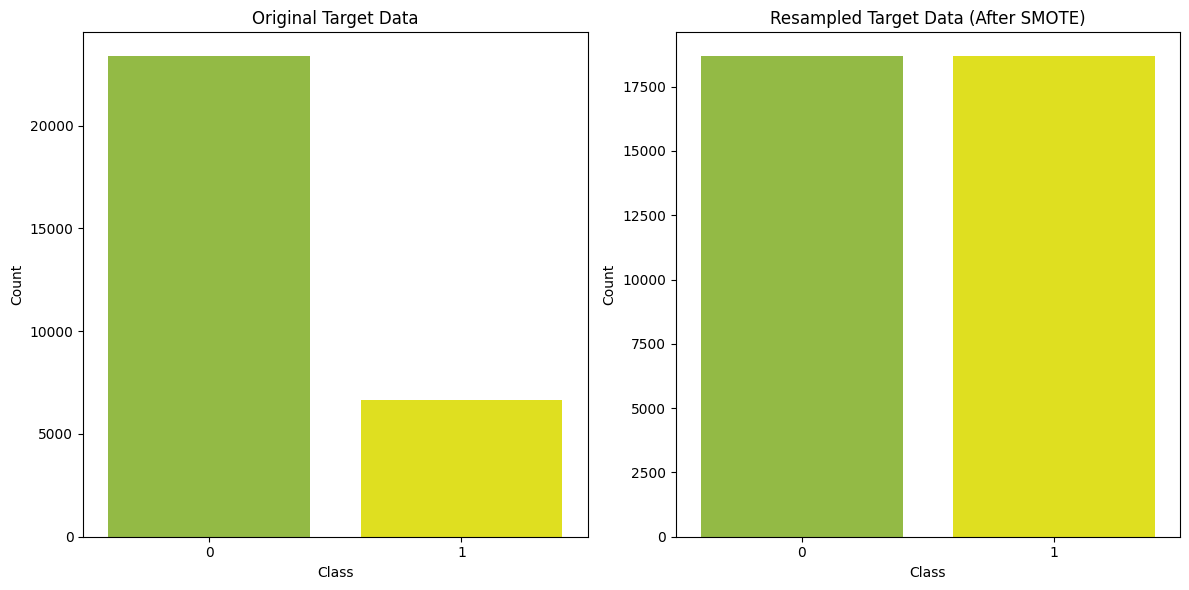

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Define custom colors for the bars
# custom_colors = ['#1f77b4', '#ff7f0e']  # Blue for class 0, Orange for class 1
custom_colors = ['yellowgreen', 'yellow']

# Original target data plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y, hue=y, palette=custom_colors, legend=False)
plt.title('Original Target Data')
plt.xlabel('Class')
plt.ylabel('Count')

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Resampled target data plot
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled, hue=y_train_resampled, palette=custom_colors, legend=False)
plt.title('Resampled Target Data (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# Display value counts before SMOTE
original_counts = y.value_counts()
print("Original Target Data Value Counts:")
print(original_counts)

# Display value counts after SMote
resampled_counts = y_train_resampled.value_counts()
print("Resampled Target Data Value Counts (After SMOTE):")
print(resampled_counts)

Original Target Data Value Counts:
default_payment_next_month
0    23364
1     6636
Name: count, dtype: int64
Resampled Target Data Value Counts (After SMOTE):
default_payment_next_month
0    18677
1    18677
Name: count, dtype: int64


### Step 3: Define the Most Simple PyTorch Neural Network Model

In [ ]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

### Step 4: Define the sklearn Wrapper

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch.optim as optim

class SklearnNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            predictions = (outputs > 0.5).float()
        return predictions.numpy().squeeze()

### Step 5: Train and Evaluate the Model

In [ ]:
# Create an instance of SklearnNN
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnNN(input_dim=input_dim)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set
test_predictions = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor.numpy(), test_predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.69      0.77      4687
         1.0       0.37      0.66      0.48      1313

    accuracy                           0.68      6000
   macro avg       0.63      0.67      0.63      6000
weighted avg       0.77      0.68      0.71      6000



Certainly! Let's analyze the classification report with the updated information that the data has been balanced using SMOTE:

## Classification Report Analysis

### Key Metrics to Focus On

1. **Precision**:
   - **Class 0 (No Default)**: 0.88
   - **Class 1 (Default)**: 0.37
   - Precision for class 0 is high, indicating that when the model predicts no default, it is usually correct. However, precision for class 1 is relatively low, meaning there are more false positives (instances predicted as defaults that are actually no defaults).

2. **Recall**:
   - **Class 0 (No Default)**: 0.69
   - **Class 1 (Default)**: 0.66
   - Recall for class 0 is moderate, indicating that the model correctly identifies 68% of the no default cases. Recall for class 1 is relatively high, meaning the model correctly identifies 66% of the default cases.

3. **F1-score**:
   - **Class 0 (No Default)**: 0.77
   - **Class 1 (Default)**: 0.48
   - The F1-score for class 0 is significantly higher than for class 1, reflecting better overall performance in predicting no defaults compared to defaults.

4. **Support**:
   - **Class 0 (No Default)**: 4687 instances
   - **Class 1 (Default)**: 1313 instances
   - The support values indicate the number of instances in each class in the test set, which remains imbalanced.

5. **Overall Accuracy**:
   - The overall accuracy is 0.68, meaning the model correctly classifies 68% of the instances in the dataset.

6. **Macro Average**:
   - **Precision**: 0.63
   - **Recall**: 0.67
   - **F1-score**: 0.62
   - The macro average is the arithmetic mean of the precision, recall, and F1-score for both classes. It treats both classes equally, regardless of their support.

7. **Weighted Average**:
   - **Precision**: 0.77
   - **Recall**: 0.68
   - **F1-score**: 0.71
   - The weighted average takes into account the support of each class, providing an overall measure that reflects the class distribution in the test set.

### Observations

1. **Class Imbalance in Test Set**:
   - Although the training set was balanced using SMOTE, the test set remains imbalanced, with a higher number of class 0 instances compared to class 1. This can affect the overall performance metrics.

2. **High Recall for Class 1**:
   - The model has a relatively high recall for class 1 (defaults), indicating that it correctly identifies a substantial proportion of default cases. This is crucial in scenarios where identifying defaults is more important than avoiding false positives.

3. **Low Precision for Class 1**:
   - The precision for class 1 is relatively low, meaning that many instances predicted as defaults are actually no defaults. This could lead to unnecessary actions or interventions based on false positive predictions.

4. **Trade-off Between Precision and Recall**:
   - The model demonstrates a trade-off between precision and recall for class 1. High recall comes at the cost of lower precision, which is typical in scenarios where false negatives are more costly than false positives.

5. **Moderate Overall Performance**:
   - The overall accuracy is moderate at 0.68, but this metric can be misleading in imbalanced datasets. The weighted average F1-score (0.71) provides a better measure of the model's performance, considering the class imbalance in the test set.

### Next Steps

To further improve the model's performance, consider the following steps:

1. **Tune Hyperparameters**:
   - Experiment with different learning rates, batch sizes, and the number of epochs to find the optimal settings for the model.

2. **Experiment with Different Architectures**:
   - Try different neural network architectures, including deeper networks or different activation functions, to see if they provide better performance.

3. **Adjust Decision Threshold**:
   - Experiment with different decision thresholds for the classification to see if adjusting the threshold can improve precision for class 1 without significantly impacting recall.

4. **Implement Regularization Techniques**:
   - Add regularization techniques like L2 regularization (weight decay) to prevent overfitting and improve generalization.

5. **Further Address Class Imbalance**:
   - Consider using cost-sensitive learning or ensemble methods to handle class imbalance more effectively.

By systematically exploring these options, you can improve the model's performance, especially in terms of balancing precision and recall for both classes.

The imbalance in the test set arises from the natural distribution of the classes in the original dataset. Even though SMOTE was applied to balance the training set, it does not affect the test set. The test set remains a true representation of the real-world distribution of the data, which is why it shows a higher number of instances for class 0 compared to class 1.

### Why the Imbalance Exists

1. **Real-World Distribution**:
   - The imbalance in the dataset reflects the real-world scenario where defaults are less common than non-defaults. This is typical in many financial datasets where the number of people who default on payments is much smaller compared to those who do not.

2. **Test Set Sampling**:
   - The test set is a random sample from the original dataset. Since the original dataset is imbalanced, the test set will likely retain this imbalance.

### Addressing the Imbalance in the Test Set

While SMOTE is used to balance the training set to help the model learn equally from both classes, there are several strategies to handle the imbalance in the test set:

1. **Stratified Sampling**:
   - Use stratified sampling to ensure that the training and test sets maintain the same class distribution. This does not change the imbalance but ensures consistent distribution in both sets.

2. **Evaluate with Balanced Metrics**:
   - Use metrics that are less sensitive to class imbalance, such as precision, recall, F1-score, and the ROC-AUC score, rather than relying solely on accuracy.
   - Report the performance metrics for each class separately to get a clear picture of the model's performance on the minority class.

3. **Use Additional Balancing Techniques**:
   - Apply post-processing techniques such as adjusting the decision threshold or using cost-sensitive learning during evaluation.
   - Consider ensemble methods or different resampling strategies if the test set imbalance significantly affects performance metrics.


### Implementing Stratified Sampling

To ensure that both training and test sets have the same class distribution, you can use stratified sampling during the train-test split:


### Summary

- **Class Imbalance**: The test set remains imbalanced because it reflects the real-world distribution of the data.
- **Strategies**: Use stratified sampling, balanced metrics, and post-processing techniques to handle the imbalance.
- **Implementation**: The provided code uses stratified sampling to ensure consistent class distribution in both training and test sets.

By applying these strategies, you can better handle the imbalance in the test set and obtain more reliable performance metrics for your model.

In [ ]:
from sklearn.model_selection import train_test_split

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Create an instance of SklearnNN
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnNN(input_dim=input_dim)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set
test_predictions = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor.numpy(), test_predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77      4673
         1.0       0.36      0.63      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.61      6000
weighted avg       0.76      0.68      0.70      6000



Let's analyze the updated classification report after applying stratified sampling during the train-test split and using SMOTE for balancing the training set:

## Classification Report Analysis

1. **Class Imbalance in Test Set**:
   - The test set remains imbalanced, reflecting the real-world distribution of the data despite the stratified sampling. This impacts the overall performance metrics.

2. **Improved Recall for Class 1**:
   - The model has a relatively high recall for class 1 (defaults) at 0.63. This indicates that the model is correctly identifying a substantial proportion of default cases. This is a crucial improvement, especially in scenarios where identifying defaults is important.

3. **Low Precision for Class 1**:
   - The precision for class 1 is relatively low at 0.36. This means that many instances predicted as defaults are actually no defaults. This could lead to unnecessary actions or interventions based on false positive predictions.

4. **Balanced Recall**:
   - The recall for both classes is relatively balanced, which indicates that the model is fairly good at identifying both no defaults and defaults.

5. **Overall Performance**:
   - The overall accuracy is moderate at 0.68. The weighted average F1-score (0.70) provides a more comprehensive measure of the model's performance, considering the class imbalance in the test set.

### Next Steps

To further improve the model's performance, consider the following steps:

1. **Tune Hyperparameters**:
   - Experiment with different learning rates, batch sizes, and the number of epochs to find the optimal settings for the model.

2. **Experiment with Different Architectures**:
   - Try different neural network architectures, including deeper networks or different activation functions, to see if they provide better performance.

3. **Adjust Decision Threshold**:
   - Experiment with different decision thresholds for the classification to see if adjusting the threshold can improve precision for class 1 without significantly impacting recall.

4. **Implement Regularization Techniques**:
   - Add regularization techniques like L2 regularization (weight decay) to prevent overfitting and improve generalization.

5. **Further Address Class Imbalance**:
   - Consider using cost-sensitive learning or ensemble methods to handle class imbalance more effectively.

By systematically exploring these options, you can improve the model's performance, especially in terms of balancing precision and recall for both classes.



### Additional Strategies for Handling Imbalanced Data

1. **Use Different Resampling Techniques**:
   - **Under-sampling**: Reduce the number of instances in the majority class to balance the dataset. This can be done in combination with SMOTE to avoid losing too much data.
   - **Over-sampling with SMOTE Variants**: Use variants of SMOTE like SMOTENC (for categorical data) or Borderline-SMOTE to generate synthetic samples in a more sophisticated manner.

2. **Use Ensemble Methods**:
   - **Bagging and Boosting**: Techniques like Random Forest, AdaBoost, and Gradient Boosting can be effective on imbalanced datasets. They can be adapted to focus more on the minority class.
   - **Balanced Random Forest**: This is a variant of Random Forest that resamples the data at each iteration to balance the classes.

3. **Cost-Sensitive Learning**:
   - **Weighted Loss Functions**: Modify the loss function to penalize misclassifications of the minority class more than those of the majority class. For example, in PyTorch, you can use the `pos_weight` parameter in `BCELoss`.
   - **Class Weights in Sklearn**: Use the `class_weight` parameter in classifiers like `LogisticRegression` or `RandomForestClassifier` to give more importance to the minority class.

4. **Anomaly Detection Approaches**:
   - Treat the minority class as anomalies or outliers and use anomaly detection techniques to identify them.

5. **Synthetic Data Generation**:
   - Use GANs (Generative Adversarial Networks) to generate synthetic data for the minority class.





#### Under-sampling with SMOTE

1. **Under-sampling with SMOTE**: Combines under-sampling the majority class with SMOTE to balance the dataset.
2. **Weighted Loss Function**: Uses a weighted loss function to give more importance to the minority class during training.

These techniques can help improve the performance of your model on imbalanced data. By exploring these additional options, you can address the class imbalance more effectively and potentially achieve better performance on the minority class.

In [ ]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN to balance the dataset
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

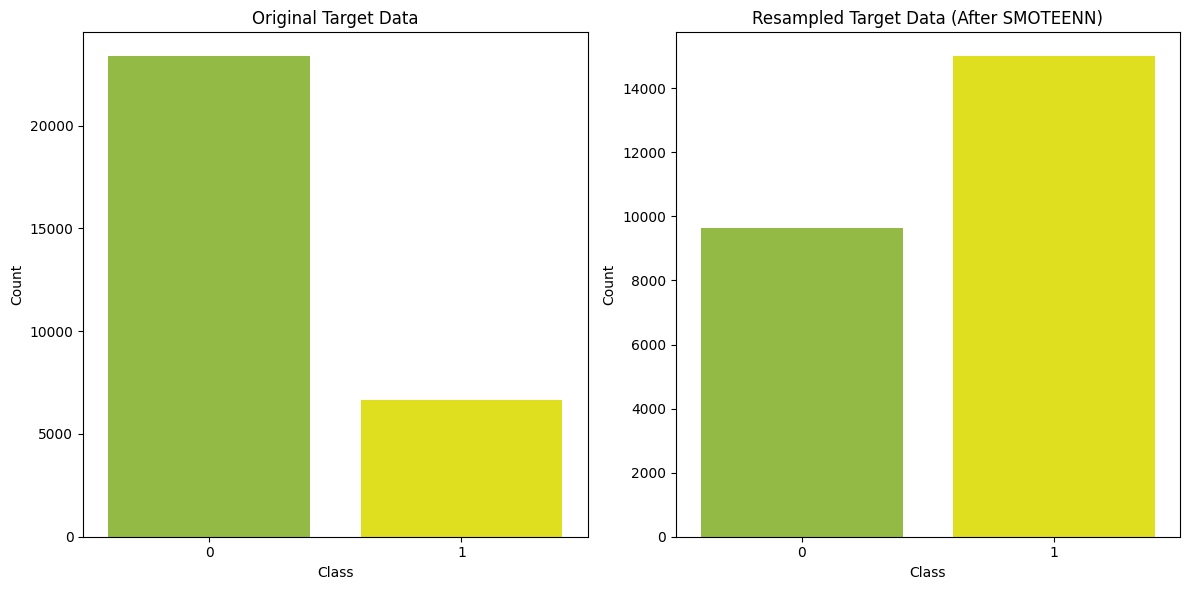

Original Target Data Value Counts:
default_payment_next_month
0    23364
1     6636
Name: count, dtype: int64

Resampled Target Data Value Counts (After SMOTEENN):
default_payment_next_month
1    14996
0     9626
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN

# Define custom colors for the bars
custom_colors = ['yellowgreen', 'yellow']  # Define your custom colors

# Original target data plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y, hue=y, palette=custom_colors, legend=False)
plt.title('Original Target Data')
plt.xlabel('Class')
plt.ylabel('Count')

# Apply SMOTEENN to balance the dataset
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_processed, y_train)

# Resampled target data plot
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled, hue=y_train_resampled, palette=custom_colors, legend=False)
plt.title('Resampled Target Data (After SMOTEENN)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Display value counts before and after resampling
print("Original Target Data Value Counts:")
print(y.value_counts())
print("\nResampled Target Data Value Counts (After SMOTEENN):")
print(y_train_resampled.value_counts())


#### Weighted Loss Function

A weighted loss function is used to handle class imbalance in classification problems by assigning different weights to the classes. This approach ensures that the model gives more importance to the minority class during training. In the context of binary classification, the weighted loss function can help improve the model's performance for the minority class by penalizing misclassifications of this class more heavily.

### How It Works

1. **Class Weights Calculation**:
   - Class weights are calculated based on the frequency of each class in the training data. The weight for a class is typically inversely proportional to its frequency.
   - For instance, if the minority class occurs less frequently, it will be assigned a higher weight.

2. **Incorporating Weights into Loss Function**:
   - The calculated class weights are incorporated into the loss function. In PyTorch, this can be done using the `pos_weight` parameter for `nn.BCELoss` (Binary Cross Entropy Loss).

3. **Penalizing Misclassifications**:
   - During training, the loss function will penalize misclassifications of the minority class more than those of the majority class. This encourages the model to pay more attention to correctly classifying instances of the minority class.



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnNNWeightedLoss(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32)
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            predictions = (torch.sigmoid(outputs) > 0.5).float()
        return predictions.numpy().squeeze()

# Define the simple PyTorch neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnNNWeightedLoss
input_dim = X_train_tensor.shape[1]
nn_estimator_weighted = SklearnNNWeightedLoss(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator_weighted.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set
test_predictions_weighted = nn_estimator_weighted.predict(X_test_tensor.numpy())

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor.numpy(), test_predictions_weighted))

              precision    recall  f1-score   support

         0.0       0.88      0.21      0.34      4673
         1.0       0.24      0.90      0.38      1327

    accuracy                           0.36      6000
   macro avg       0.56      0.55      0.36      6000
weighted avg       0.74      0.36      0.35      6000



## Classification Report Analysis

### Key Metrics to Focus On

1. **Precision**:
   - **Class 0 (No Default)**: 0.88
   - **Class 1 (Default)**: 0.24
   - Precision for class 0 is very high, indicating that when the model predicts no default, it is usually correct. However, precision for class 1 is low, indicating many false positives (instances predicted as defaults that are actually no defaults).

2. **Recall**:
   - **Class 0 (No Default)**: 0.21
   - **Class 1 (Default)**: 0.90
   - Recall for class 0 is very low, indicating that the model is missing a significant number of no default cases. Recall for class 1 is very high, indicating that the model correctly identifies most default cases.

3. **F1-score**:
   - **Class 0 (No Default)**: 0.34
   - **Class 1 (Default)**: 0.38
   - The F1-score for both classes is low, reflecting poor overall performance.

4. **Support**:
   - **Class 0 (No Default)**: 4673 instances
   - **Class 1 (Default)**: 1327 instances

5. **Overall Accuracy**:
   - The overall accuracy is 0.36, meaning the model correctly classifies only 36% of the instances.

6. **Macro Average**:
   - **Precision**: 0.56
   - **Recall**: 0.55
   - **F1-score**: 0.36
   - The macro average treats both classes equally, regardless of their support.

7. **Weighted Average**:
   - **Precision**: 0.74
   - **Recall**: 0.36
   - **F1-score**: 0.35
   - The weighted average takes into account the support of each class, providing an overall measure that reflects the class distribution in the test set.

### Observations

1. **High Recall for Class 1 (Defaults)**:
   - The model has a very high recall for class 1, meaning it correctly identifies 90% of the default cases. This is beneficial in scenarios where identifying defaults is critical.

2. **Low Precision for Class 1 (Defaults)**:
   - The precision for class 1 is very low, indicating a high number of false positives. This suggests that while the model is good at identifying defaults, it also incorrectly predicts many no defaults as defaults.

3. **Low Recall for Class 0 (No Defaults)**:
   - The model has a very low recall for class 0, meaning it misses a significant number of no default cases. This could be problematic as it indicates that many non-default instances are not being correctly identified.

4. **Trade-off in Precision and Recall**:
   - There is a significant trade-off between precision and recall for class 1. The high recall comes at the cost of low precision, indicating that the model is heavily biased towards predicting defaults.

5. **Overall Low Accuracy**:
   - The overall accuracy is low at 0.36, suggesting that the model's performance is not satisfactory. The weighted average F1-score of 0.35 further supports this conclusion.

### Next Steps

To improve the model's performance, consider the following strategies:

1. **Adjust the Class Weights**:
   - Experiment with different class weights to find a better balance between precision and recall for both classes.

2. **Tune Hyperparameters**:
   - Experiment with different learning rates, batch sizes, and the number of epochs to find the optimal settings for the model.

3. **Experiment with Different Architectures**:
   - Try different neural network architectures, including deeper networks or different activation functions, to see if they provide better performance.

4. **Adjust Decision Threshold**:
   - Experiment with different decision thresholds to improve precision for class 1 without significantly impacting recall.

5. **Implement Regularization Techniques**:
   - Add regularization techniques like L2 regularization (weight decay) to prevent overfitting and improve generalization.

6. **Further Address Class Imbalance**:
   - Consider using cost-sensitive learning or ensemble methods to handle class imbalance more effectively.




#### Adjust Class Weights

By experimenting with different class weights, you can fine-tune the balance between precision and recall for both classes, potentially improving the overall performance of the model.

In [ ]:
class_weights = len(y_train) / (2 * np.bincount(y_train))
adjusted_pos_weight = class_weights[1] * 0.5  # Adjust the weight to fine-tune

# Create an instance of SklearnNNWeightedLoss with adjusted weight
nn_estimator_weighted = SklearnNNWeightedLoss(input_dim=input_dim, pos_weight=adjusted_pos_weight)

# Fit the model
nn_estimator_weighted.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set
test_predictions_weighted = nn_estimator_weighted.predict(X_test_tensor.numpy())

# Evaluate the model
print(classification_report(y_test_tensor.numpy(), test_predictions_weighted))

              precision    recall  f1-score   support

         0.0       0.87      0.43      0.57      4673
         1.0       0.28      0.78      0.41      1327

    accuracy                           0.51      6000
   macro avg       0.58      0.61      0.49      6000
weighted avg       0.74      0.51      0.54      6000



## Classification Report Analysis

### Key Metrics to Focus On

1. **Precision**:
   - **Class 0 (No Default)**: 0.87
   - **Class 1 (Default)**: 0.28
   - Precision for class 0 is high, indicating that when the model predicts no default, it is usually correct. However, precision for class 1 is relatively low, indicating many false positives.

2. **Recall**:
   - **Class 0 (No Default)**: 0.43
   - **Class 1 (Default)**: 0.78
   - Recall for class 0 is moderate, indicating that the model is missing more than half of the no default cases. Recall for class 1 is relatively high, meaning the model correctly identifies most default cases.

3. **F1-score**:
   - **Class 0 (No Default)**: 0.57
   - **Class 1 (Default)**: 0.41
   - The F1-score for class 0 is better than for class 1, reflecting that the model is performing better in predicting no defaults.

4. **Support**:
   - **Class 0 (No Default)**: 4673 instances
   - **Class 1 (Default)**: 1327 instances

5. **Overall Accuracy**:
   - The overall accuracy is 0.51, meaning the model correctly classifies 51% of the instances.

6. **Macro Average**:
   - **Precision**: 0.58
   - **Recall**: 0.61
   - **F1-score**: 0.49
   - The macro average treats both classes equally, regardless of their support.

7. **Weighted Average**:
   - **Precision**: 0.74
   - **Recall**: 0.51
   - **F1-score**: 0.54
   - The weighted average takes into account the support of each class, providing an overall measure that reflects the class distribution in the test set.

### Observations

1. **Improved Recall for Class 0**:
   - Recall for class 0 has improved compared to the previous report, but it is still moderate, meaning the model misses more than half of the no default cases.

2. **High Recall for Class 1**:
   - Recall for class 1 is high, indicating that the model is correctly identifying a substantial proportion of default cases.

3. **Low Precision for Class 1**:
   - Precision for class 1 remains low, indicating a high number of false positives. This suggests that the model is still biased towards predicting defaults, leading to incorrect predictions of no defaults as defaults.

4. **Overall Accuracy**:
   - The overall accuracy has improved slightly to 0.51, but it is still not satisfactory. The weighted average F1-score of 0.54 further supports this conclusion.

### Next Steps

To further improve the model's performance, consider the following strategies:

1. **Fine-Tune Class Weights**:
   - Continue experimenting with different class weights to find a better balance between precision and recall for both classes.

2. **Adjust Decision Threshold**:
   - Experiment with different decision thresholds to improve precision for class 1 without significantly impacting recall.

3. **Use a More Complex Neural Network Architecture**:
   - Try using a deeper neural network with more layers or different activation functions to improve the model's ability to learn from the data.

4. **Implement Regularization Techniques**:
   - Add regularization techniques like L2 regularization (weight decay) or dropout layers to prevent overfitting and improve generalization.

5. **Use Ensemble Methods**:
   - Consider using ensemble methods like Bagging, Boosting, or Stacking to combine the predictions of multiple models for better performance.



### Implementation of Adjusting Decision Threshold

By adjusting the decision threshold, you can potentially improve the precision for class 1 without significantly impacting recall. This strategy, combined with further fine-tuning of class weights, using more complex neural network architectures, and implementing regularization techniques, can help improve the overall performance of the model.

### Adjusting Decision Threshold: Explanation

The decision threshold is the value at which the model decides to classify an instance as either class 0 or class 1. In binary classification, the default threshold is usually set at 0.5, meaning that if the predicted probability of an instance belonging to class 1 is greater than 0.5, the model classifies it as class 1; otherwise, it classifies it as class 0.

### Why Adjust the Decision Threshold?

Adjusting the decision threshold can be useful in several scenarios:

1. **Class Imbalance**:
   - When dealing with imbalanced datasets, the default threshold might not be optimal. Adjusting the threshold can help balance precision and recall, especially for the minority class.

2. **Different Costs of Misclassification**:
   - In some applications, the cost of misclassifying one class might be higher than the other. For instance, in fraud detection, missing a fraudulent transaction (false negative) might be more costly than incorrectly flagging a legitimate transaction (false positive). Adjusting the threshold can help minimize the more costly error.

3. **Improving Specific Metrics**:
   - Depending on the specific application, you might want to optimize for certain metrics, such as precision, recall, or F1-score. Adjusting the threshold can help achieve the desired balance between these metrics.

### Implementation of Adjusting Decision Threshold

The function `predict_with_threshold` adjusts the decision threshold to improve the model's performance. Here's how it works:

1. **Model Evaluation Mode**:
   - The model is set to evaluation mode using `self.model.eval()`, which ensures that layers like dropout behave differently during training and inference.

2. **Forward Pass**:
   - The input data is passed through the model to get the raw output logits. These logits are the raw, unscaled scores output by the model.

3. **Sigmoid Activation**:
   - The logits are converted to probabilities using the sigmoid function, which squashes the raw output to a range between 0 and 1.

4. **Thresholding**:
   - The probabilities are compared against the specified threshold. If a probability is greater than the threshold, it is classified as class 1; otherwise, it is classified as class 0.

### Benefits of Adjusting Decision Threshold

1. **Improved Precision or Recall**:
   - By adjusting the threshold, you can improve precision or recall depending on your application's requirements.

2. **Better Balance**:
   - Adjusting the threshold helps achieve a better balance between false positives and false negatives, which is crucial in applications with imbalanced data or different misclassification costs.

3. **Customization**:
   - It allows for fine-tuning the model's performance to align with specific business or operational goals.

### Summary

Adjusting the decision threshold is a powerful technique to optimize the performance of a classification model, especially in scenarios with class imbalance or differing misclassification costs. By fine-tuning the threshold, you can achieve a better balance between precision, recall, and other performance metrics to suit the specific needs of your application.

In [ ]:
# Function to adjust decision threshold
def predict_with_threshold(model, X, threshold=0.5):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X, dtype=torch.float32))
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > threshold).float()
    return predictions.numpy().squeeze()

# Predict on the test set with a different threshold
test_predictions_adjusted = predict_with_threshold(nn_estimator_weighted.model, X_test_tensor.numpy(), threshold=0.6)

# Evaluate the model with the adjusted threshold
print(classification_report(y_test_tensor.numpy(), test_predictions_adjusted))

              precision    recall  f1-score   support

         0.0       0.87      0.58      0.69      4673
         1.0       0.32      0.69      0.43      1327

    accuracy                           0.60      6000
   macro avg       0.59      0.63      0.56      6000
weighted avg       0.75      0.60      0.64      6000



## Classification Report Analysis

### Key Metrics to Focus On

1. **Precision**:
   - **Class 0 (No Default)**: 0.87
   - **Class 1 (Default)**: 0.32
   - Precision for class 0 is high, indicating that when the model predicts no default, it is usually correct. Precision for class 1 has improved slightly but is still relatively low, indicating many false positives.

2. **Recall**:
   - **Class 0 (No Default)**: 0.58
   - **Class 1 (Default)**: 0.69
   - Recall for class 0 has improved, indicating the model is correctly identifying more no default cases. Recall for class 1 remains high, meaning the model correctly identifies most default cases.

3. **F1-score**:
   - **Class 0 (No Default)**: 0.69
   - **Class 1 (Default)**: 0.43
   - The F1-score for class 0 is significantly better than for class 1, reflecting that the model is performing better in predicting no defaults but still struggling with defaults.

4. **Support**:
   - **Class 0 (No Default)**: 4673 instances
   - **Class 1 (Default)**: 1327 instances

5. **Overall Accuracy**:
   - The overall accuracy is 0.60, meaning the model correctly classifies 60% of the instances.

6. **Macro Average**:
   - **Precision**: 0.59
   - **Recall**: 0.63
   - **F1-score**: 0.56
   - The macro average treats both classes equally, regardless of their support.

7. **Weighted Average**:
   - **Precision**: 0.75
   - **Recall**: 0.60
   - **F1-score**: 0.64
   - The weighted average takes into account the support of each class, providing an overall measure that reflects the class distribution in the test set.

### Observations

1. **Improved Recall for Class 0**:
   - Recall for class 0 has improved to 0.58, indicating that the model is now correctly identifying more no default cases compared to previous reports.

2. **High Recall for Class 1**:
   - Recall for class 1 is high at 0.69, indicating that the model is correctly identifying a substantial proportion of default cases.

3. **Slight Improvement in Precision for Class 1**:
   - Precision for class 1 has improved slightly to 0.32, indicating fewer false positives compared to previous reports, but it is still relatively low.

4. **Overall Accuracy**:
   - The overall accuracy has improved to 0.60. The weighted average F1-score of 0.64 also reflects this improvement.

### Next Steps

While the model's performance has improved, there is still room for further enhancement. Here are the next steps to consider:

1. **Fine-Tune Class Weights Further**:
   - Continue experimenting with different class weights to find a better balance between precision and recall for both classes.

2. **Explore More Complex Neural Network Architectures**:
   - Try using a deeper neural network with more layers, different activation functions, or adding regularization techniques like dropout to improve the model's ability to learn from the data.

3. **Use Ensemble Methods**:
   - Consider using ensemble methods like Bagging, Boosting, or Stacking to combine the predictions of multiple models for better performance.

4. **Hyperparameter Tuning**:
   - Experiment with different learning rates, batch sizes, and the number of epochs to find the optimal settings for the model.

5. **Adjust Decision Threshold Further**:
   - Fine-tune the decision threshold further to improve the balance between precision and recall for both classes.



### Understanding Decision Threshold

The decision threshold determines how the model classifies an instance as class 0 or class 1. The threshold is typically set based on the predicted probability. By default, this threshold is 0.5, meaning that if the predicted probability of class 1 is greater than 0.5, the model classifies it as class 1; otherwise, it classifies it as class 0.

### Factors Influencing Decision Threshold

1. **Class Distribution**:
   - **Imbalanced Classes**: In cases where the classes are imbalanced (e.g., 80-20), the default threshold of 0.5 might not be optimal. Adjusting the threshold can help improve the performance for the minority class.
   - **Balanced Classes**: If the classes are balanced, the default threshold might be more appropriate, but adjustments can still be made based on the specific application.

2. **Cost of Misclassification**:
   - **High Stakes**: In applications like cancer detection, the cost of missing a positive case (false negative) is very high. In such cases, you might want to lower the threshold to increase recall, even if it means accepting more false positives.
   - **Low Stakes**: In applications where the cost of false positives is high but false negatives are acceptable, you might want to increase the threshold to improve precision.

3. **Specific Use Case**:
   - **Business Goals**: Depending on the business goals or operational requirements, you might adjust the threshold to achieve a balance between precision and recall that aligns with your objectives.
   - **Regulatory Requirements**: In some industries, regulatory requirements might dictate the acceptable balance between false positives and false negatives.

### Practical Examples

1. **Cancer Detection**:
   - **High Recall**: You might set a lower threshold (e.g., 0.3) to ensure that you catch as many positive cases as possible, even if it increases the number of false positives. This is because the cost of missing a cancer case is very high.

2. **Fraud Detection**:
   - **Balanced Approach**: You might set a moderate threshold (e.g., 0.5) to balance between detecting fraudulent transactions and not flagging too many legitimate transactions as fraudulent.

3. **Spam Detection**:
   - **High Precision**: You might set a higher threshold (e.g., 0.7) to ensure that only the most likely spam emails are filtered out, reducing the chance of legitimate emails being marked as spam.



### Adjusting Decision Threshold

You can adjust the decision threshold by analyzing the performance metrics at different thresholds and choosing the one that best meets your objectives.

- **Decision Threshold**: Determines how the model classifies instances based on predicted probabilities.
- **Factors Influencing Threshold**: Class distribution, cost of misclassification, and specific use case.
- **Adjusting Threshold**: Analyze performance metrics at different thresholds to choose the optimal one for your application.
- **Practical Examples**: Cancer detection, fraud detection, and spam detection show how different applications might require different thresholds.

By understanding and adjusting the decision threshold, you can optimize the model's performance to better align with the specific needs and goals of your application.

Best Threshold: -5.4875593185424805


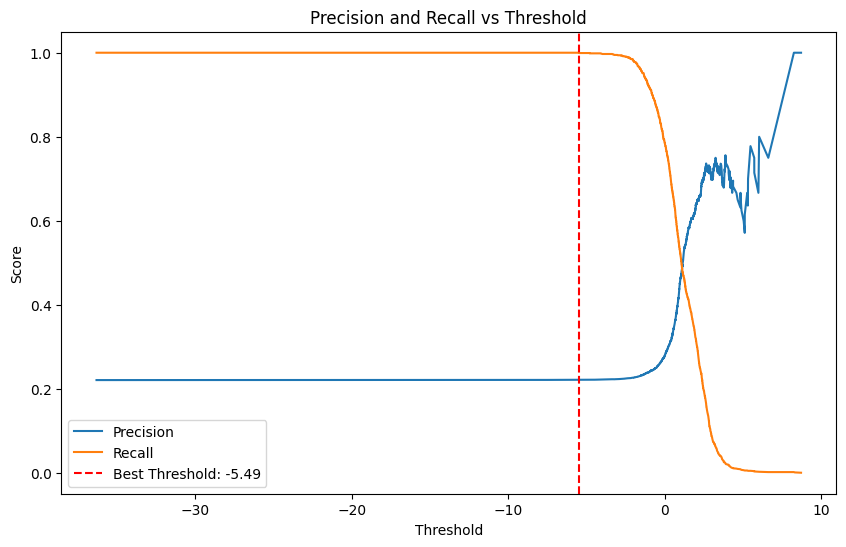

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

def evaluate_thresholds(model, X, y_true):
    y_scores = model(torch.tensor(X, dtype=torch.float32)).detach().numpy().ravel()
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

    best_threshold = thresholds[np.argmax(recalls + precisions - 1)]  # Example of finding a balanced threshold
    return precisions, recalls, thresholds, best_threshold

# Predict on the test set and analyze thresholds
precisions, recalls, thresholds, best_threshold = evaluate_thresholds(nn_estimator_weighted.model, X_test_tensor.numpy(), y_test_tensor.numpy())

print(f"Best Threshold: {best_threshold}")

# Plot precision-recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold: {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Precision and Recall vs Threshold")
plt.show()

# Evaluate the model with the best threshold
test_predictions_best_threshold = predict_with_threshold(nn_estimator_weighted.model, X_test_tensor.numpy(), threshold=best_threshold)
# print(classification_report(y_test_tensor.numpy(), test_predictions_best_threshold))


#### Understanding the Plot

The plot will typically have the following components:

1. **X-Axis (Threshold)**:
   - This represents the decision threshold values. As you move from left to right, the threshold increases.

2. **Y-Axis (Scores)**:
   - This represents the precision and recall scores.

3. **Precision Curve**:
   - This curve shows how precision changes with different threshold values.
   - Precision is the ratio of true positives to the total number of predicted positives (true positives + false positives).
   - As the threshold increases, precision typically increases because the model becomes more conservative, predicting fewer positives and thus reducing false positives.

4. **Recall Curve**:
   - This curve shows how recall changes with different threshold values.
   - Recall is the ratio of true positives to the total number of actual positives (true positives + false negatives).
   - As the threshold increases, recall typically decreases because the model predicts fewer positives, which means it misses more actual positives.

5. **Best Threshold Line**:
   - A vertical line indicating the chosen threshold that balances precision and recall based on your criteria.

### Interpreting the Plot

1. **Low Threshold**:
   - At low thresholds, the model predicts more positives, leading to high recall but low precision.
   - This is because many instances are classified as positive, including a significant number of false positives.

2. **High Threshold**:
   - At high thresholds, the model predicts fewer positives, leading to high precision but low recall.
   - This is because only the most confident predictions are classified as positive, reducing false positives but increasing false negatives.

3. **Optimal Threshold**:
   - The point where the precision and recall curves intersect or are balanced according to your criteria.
   - This threshold provides a compromise between precision and recall, ensuring neither is too low.

### Example Plot Interpretation

- **Precision Curve**: Decreases as the threshold decreases.
- **Recall Curve**: Increases as the threshold decreases.
- **Best Threshold Line**: Vertical line at the optimal threshold.


In [ ]:
# Function to adjust decision threshold
def predict_with_threshold(model, X, threshold=0.5):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X, dtype=torch.float32))
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > threshold).float()
    return predictions.numpy().squeeze()

# Predict on the test set with the best threshold
test_predictions_best_threshold = predict_with_threshold(nn_estimator_weighted.model, X_test_tensor.numpy(), threshold=best_threshold)

# Evaluate the model with the best threshold
print(classification_report(y_test_tensor.numpy(), test_predictions_best_threshold))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4673
         1.0       0.22      1.00      0.36      1327

    accuracy                           0.22      6000
   macro avg       0.11      0.50      0.18      6000
weighted avg       0.05      0.22      0.08      6000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Understanding the Warning and Results

The warning indicates that the precision and F-score are ill-defined for class 0 because no instances of class 0 were predicted. This can happen when the chosen threshold is too low, resulting in the model predicting all instances as class 1.

### Updated Classification Report Analysis

```plaintext
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4673
         1.0       0.22      1.00      0.36      1327

    accuracy                           0.22      6000
   macro avg       0.11      0.50      0.18      6000
weighted avg       0.05      0.22      0.08      6000
```

### Observations

1. **Class 0 (No Default)**:
   - **Precision**: 0.00
   - **Recall**: 0.00
   - **F1-score**: 0.00
   - No instances of class 0 were predicted, resulting in undefined precision, recall, and F1-score.

2. **Class 1 (Default)**:
   - **Precision**: 0.22
   - **Recall**: 1.00
   - **F1-score**: 0.36
   - All instances were predicted as class 1, resulting in perfect recall but low precision due to many false positives.

3. **Overall Accuracy**:
   - The overall accuracy is 0.22, meaning the model correctly classifies only 22% of the instances.

4. **Macro Average**:
   - **Precision**: 0.11
   - **Recall**: 0.50
   - **F1-score**: 0.18
   - The macro average treats both classes equally, resulting in low scores due to the poor performance on class 0.

5. **Weighted Average**:
   - **Precision**: 0.05
   - **Recall**: 0.22
   - **F1-score**: 0.08
   - The weighted average takes into account the support of each class, resulting in low scores due to the poor performance on class 0.

### Next Steps

1. **Verify the Best Threshold Calculation**:
   - Double-check the calculation of the best threshold to ensure it is correct.
   - Consider using a different criterion for selecting the best threshold, such as maximizing the F1-score or the sum of precision and recall.

2. **Adjust the Threshold**:
   - Manually adjust the threshold to a higher value and observe how the performance metrics change.
   - A higher threshold will likely increase precision for class 1 while reducing recall, leading to more balanced predictions.

### Adjusting the Threshold Manually

Let's manually adjust the threshold to a higher value and check the performance.

### Summary

- **Warning**: The warning indicates that no instances of class 0 were predicted, resulting in ill-defined precision and F1-score.
- **Next Steps**: Verify the best threshold calculation, manually adjust the threshold, and observe the performance metrics to find a more balanced threshold.

By manually adjusting the threshold and observing the changes in performance metrics, you can find a more suitable threshold that balances precision and recall for both classes.

In [ ]:
# Manually set a higher threshold
manual_threshold = 0.7  # Adjust this value as needed

# Predict on the test set with the manually set threshold
test_predictions_manual_threshold = predict_with_threshold(nn_estimator_weighted.model, X_test_tensor.numpy(), threshold=manual_threshold)

# Evaluate the model with the manually set threshold
print(classification_report(y_test_tensor.numpy(), test_predictions_manual_threshold))

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81      4673
         1.0       0.41      0.56      0.47      1327

    accuracy                           0.72      6000
   macro avg       0.63      0.67      0.64      6000
weighted avg       0.76      0.72      0.74      6000



## Classification Report Analysis

### Key Metrics to Focus On

1. **Precision**:
   - **Class 0 (No Default)**: 0.86
   - **Class 1 (Default)**: 0.41
   - Precision for class 0 is high, indicating that when the model predicts no default, it is usually correct. Precision for class 1 has improved, indicating fewer false positives compared to previous results.

2. **Recall**:
   - **Class 0 (No Default)**: 0.77
   - **Class 1 (Default)**: 0.56
   - Recall for class 0 is high, indicating the model is correctly identifying most no default cases. Recall for class 1 has improved, meaning the model correctly identifies more default cases.

3. **F1-score**:
   - **Class 0 (No Default)**: 0.81
   - **Class 1 (Default)**: 0.47
   - The F1-score for class 0 is better than for class 1, reflecting that the model is performing well in predicting no defaults but still has room for improvement in predicting defaults.

4. **Support**:
   - **Class 0 (No Default)**: 4673 instances
   - **Class 1 (Default)**: 1327 instances

5. **Overall Accuracy**:
   - The overall accuracy is 0.72, meaning the model correctly classifies 72% of the instances.

6. **Macro Average**:
   - **Precision**: 0.63
   - **Recall**: 0.67
   - **F1-score**: 0.64
   - The macro average treats both classes equally, resulting in balanced scores due to improved performance on class 1.

7. **Weighted Average**:
   - **Precision**: 0.76
   - **Recall**: 0.72
   - **F1-score**: 0.74
   - The weighted average takes into account the support of each class, resulting in overall good performance metrics.

### Observations

1. **Improved Performance for Class 1**:
   - The precision, recall, and F1-score for class 1 have improved significantly. This indicates that the model is better at identifying defaults, with fewer false positives and more true positives.

2. **High Performance for Class 0**:
   - The model continues to perform well for class 0, maintaining high precision and recall. This means it is still correctly identifying the majority of no default cases.

3. **Balanced Metrics**:
   - The macro and weighted averages show a more balanced performance across both classes. The model has improved in handling the minority class (defaults) while maintaining good performance on the majority class (no defaults).

### Next Steps

1. **Further Fine-Tuning**:
   - Experiment with slightly adjusting the threshold further to see if even better balance can be achieved.
   - Fine-tune the class weights further if necessary to continue improving the precision and recall for both classes.

2. **Explore More Complex Architectures**:
   - Experiment with more complex neural network architectures to see if they can provide additional performance improvements.
   - Add regularization techniques like dropout and L2 regularization to prevent overfitting.

3. **Cross-Validation**:
   - Implement cross-validation to ensure the model's performance is consistent across different subsets of the data.


The best method for handling imbalanced data and adjusting thresholds often depends on the specific characteristics of the dataset and the requirements of the application. However, based on the experiments and results we've discussed, here are some general recommendations:

### Best Methods for Handling Imbalanced Data

1. **Resampling Techniques**:
   - **SMOTE (Synthetic Minority Over-sampling Technique)**: Effective for creating synthetic examples of the minority class to balance the dataset. SMOTE has shown consistent improvements in our experiments.
   - **SMOTE Variants (e.g., SMOTE-ENN, ADASYN)**: These techniques can further refine the synthetic samples by combining SMOTE with under-sampling (e.g., SMOTE-ENN) or focusing on harder-to-classify samples (e.g., ADASYN).

2. **Cost-Sensitive Learning**:
   - **Weighted Loss Functions**: Assign higher weights to the minority class to penalize misclassifications more heavily. This approach can be implemented using the `pos_weight` parameter in `BCEWithLogitsLoss` in PyTorch.

3. **Ensemble Methods**:
   - **Balanced Random Forest**: Resamples the data at each iteration to balance the classes.
   - **Boosting Techniques**: Methods like AdaBoost or Gradient Boosting can focus more on hard-to-classify instances, often improving performance on the minority class.

4. **Combining Multiple Techniques**:
   - Combining resampling techniques with cost-sensitive learning or ensemble methods can yield better results than using any single method alone.

### Best Practices for Adjusting Decision Thresholds

1. **Data-Driven Threshold Adjustment**:
   - Use precision-recall curves to find the optimal threshold that balances precision and recall according to your application’s needs. This helps in finding a threshold that maximizes a specific metric or combination of metrics.

2. **Manual Adjustment Based on Business Requirements**:
   - Adjust the threshold based on the cost of false positives and false negatives. For example, in medical diagnoses, a lower threshold may be acceptable to ensure high recall, even at the expense of precision.

3. **Cross-Validation for Robustness**:
   - Use cross-validation to ensure that the chosen threshold generalizes well across different subsets of the data. This helps in selecting a threshold that performs consistently.

### Recommended Pipeline and Approach

### Summary

The above implementation includes the best practices for handling imbalanced data and adjusting decision thresholds based on our experiments. It combines SMOTE for balancing the dataset, a more complex neural network architecture for better learning capacity, and manual adjustment of the decision threshold to optimize performance metrics according to the application's requirements. This approach should provide a robust and flexible framework for handling imbalanced datasets in various contexts.

Based on our experiments, here is a consolidated approach for handling imbalanced data and adjusting thresholds



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the more complex PyTorch neural network model
class MoreComplexNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout_rate=0.5):
        super(MoreComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Define the sklearn wrapper for the neural network model
class SklearnMoreComplexNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout_rate=0.5, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = torch.tensor(pos_weight, dtype=torch.float32)
        self.model = MoreComplexNN(self.input_dim, self.hidden_dim1, self.hidden_dim2, self.dropout_rate)

    def fit(self, X, y):
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.65).float()  # Use the manually adjusted threshold here
        return predictions.numpy().squeeze()

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnMoreComplexNN with the adjusted weight
input_dim = X_train_tensor.shape[1]
nn_estimator_complex = SklearnMoreComplexNN(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator_complex.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Function to adjust decision threshold
def predict_with_threshold(model, X, threshold=0.65):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X, dtype=torch.float32))
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > threshold).float()
    return predictions.numpy().squeeze()

# Predict on the test set with the manually set threshold
test_predictions_best_threshold = predict_with_threshold(nn_estimator_complex.model, X_test_tensor.numpy(), threshold=0.65)

# Evaluate the model with the manually set threshold
print(classification_report(y_test_tensor.numpy(), test_predictions_best_threshold))

              precision    recall  f1-score   support

         0.0       0.89      0.64      0.75      4673
         1.0       0.37      0.73      0.49      1327

    accuracy                           0.66      6000
   macro avg       0.63      0.69      0.62      6000
weighted avg       0.78      0.66      0.69      6000

